In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bnk.quantum import Space
from bnk.tensor import ZERO

# Structure

## Atom Structure

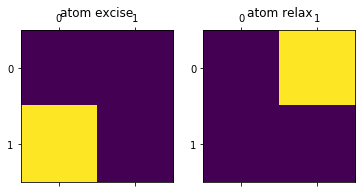

In [2]:
atom_space = Space(2, name='atom', key=1)

atom_excise = atom_space.eigenstate(1) @ atom_space.eigenstate(0).ct
atom_relax = atom_excise.ct


plt.subplot(1, 2, 1)
plt.matshow(atom_excise.flattened_values, 0)
plt.title("atom excise")

plt.subplot(1, 2, 2)
plt.matshow(atom_relax.flattened_values, 0)
plt.title("atom relax")

plt.show()

## Field Structure

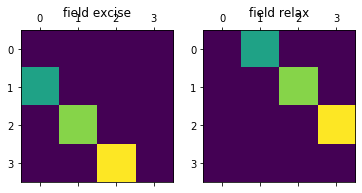

In [3]:
field_space = Space(4, name='field', key=0)

field_excise = ZERO
for i in range(1, field_space.n):
    field_excise_i = field_space.eigenstate(i) @ field_space.eigenstate(i - 1).ct
    field_excise += np.sqrt(i) * field_excise_i
field_relax = field_excise.ct


plt.subplot(1, 2, 1)
plt.matshow(field_excise.flattened_values, 0)
plt.title("field excise")

plt.subplot(1, 2, 2)
plt.matshow(field_relax.flattened_values, 0)
plt.title("field relax")

plt.show()

# Evolution

## Hamiltonian

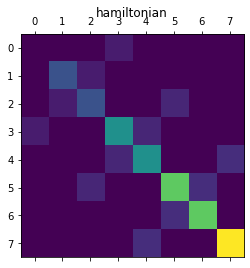

In [4]:
hb = 1
w = 1
g = 0.3

interaction = (
    atom_relax @ field_excise +
    atom_excise @ field_relax +
    atom_excise @ field_excise +
    atom_relax @ field_relax
)

hamiltonian = (
    hb * w * atom_excise @ atom_relax @ field_space.identity_operator() +
    hb * w * field_excise @ field_relax @ atom_space.identity_operator() +
    g * interaction)


plt.matshow(hamiltonian.flattened_values)
plt.title("hamiltonian")
plt.show()

## Evolution

In [5]:
def evolve(rho):
    return hamiltonian @ rho - rho @ hamiltonian

# Iteration

## Initial $\rho$

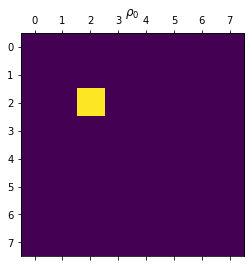

In [6]:
initial_atom_state = atom_space.eigenstate(0)
initial_field_state = field_space.eigenstate(1)
initial_state = initial_atom_state @ initial_field_state
initial_rho = initial_state @ initial_state.ct


plt.matshow(initial_rho.flattened_values)
plt.title("$\\rho_0$")
plt.show()

## Configurations

In [7]:
dt = 0.001
mt = 20

logs_dt = 0.1

## Iterations

In [8]:
%%time

t = 0.0
rho = initial_rho

logs_t = float('-inf')
logs = []

while t < mt:
    t += dt
    rho += evolve(rho) * (dt / (1j * hb))
    
    if t - logs_t > logs_dt:
        logs_t = t
        
        atom = atom_space.eigenstate(1).ct @ rho.trace(field_space) @ atom_space.eigenstate(1)
        field = field_space.eigenstate(1).ct @ rho.trace(atom_space) @ field_space.eigenstate(1)
        logs.append((t, atom, field))
        
        print(f"\rcomputing...{t/mt:.2%}", end='')
        
print("\nfinished")

computing...99.55%
finished
Wall time: 7.4 s


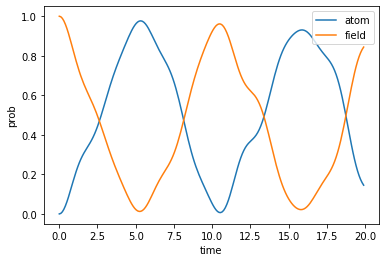

In [9]:
logs_ts, logs_atoms, logs_fields = np.transpose(logs)
plt.plot(logs_ts, logs_atoms, label='atom')
plt.plot(logs_ts, logs_fields, label='field')
plt.legend()
plt.xlabel("time")
plt.ylabel("prob")
plt.show()
